In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN

Os dados contidos na planilha 'bureau_balance' demonstram o status de cada empréstimo mês a mês para todos os clientes. Vamos verificar como se comportam os dados:

In [2]:
#df_bureau_balance = pd.read_csv('bureau_balance.csv')

In [3]:
#df_bureau_balance.info()

In [4]:
#df_bureau_balance.head()

In [5]:
#df_bureau_balance['STATUS'].value_counts()

Percebe-se que há uma certa quantidade de dados 'missing' (os dados de status marcados como 'X'). Como estes estão distribuidos entre os dados preenchidos sem nenhum padrão, muitas vezes não havendo nenhum dado preenchido para certos ID's, é difícil intuir uma forma precisa de preenchimento. Como os dados ausentes representam menos de 20% da base total, estes serão considerados apenas como 0 ou C, que representam meses com pagamento em dia. Como o intuito desta parte da análise é verificar se em algum dos meses houve inadimplencia, qualquer mês que seja, não haverá tanto impacto se a consideração for feita desta forma.

Será criado um DF auxiliar, que irá receber um valor unitário para cada mês de inadimplencia do empréstimo (coluna AUX). Esse dataframe será então agrupado pelos ID's, e todos os empréstimos que estiverem com a contagem maior do que 0 (representando que houve inadimplência em algum mês) receberão valor 1 na nova coluna 'DEFAULT', enquanto que os demais receberão valor 0. Essa nova coluna vai indicar se há histórico de inadimplência para cada empréstimo, sendo 0 = não e 1 = sim.

In [6]:
#df_aux=df_bureau_balance.copy()
#df_aux['AUX']=np.where(((df_aux['STATUS'] == '1') | (df_aux['STATUS'] == '2') | (df_aux['STATUS'] == '3') | (df_aux['STATUS'] == '4') | (df_aux['STATUS'] == '5')), 1, 0)
#df_aux = df_aux.groupby(['SK_ID_BUREAU']).sum().drop(['MONTHS_BALANCE'],axis='columns')
#df_aux['DEFAULT']=np.where(df_aux['AUX']>=1,1,0)
#df_aux.head(10)

Vamos confrontar os dados com o dataframe original e verificar se os ID's sinalizados com default 1 realmente possuem histórico de inadimplência:

In [7]:
#df_bureau_balance[df_bureau_balance['SK_ID_BUREAU']==5001717]['STATUS'].value_counts()

In [8]:
#df_bureau_balance[df_bureau_balance['SK_ID_BUREAU']==5001718]['STATUS'].value_counts()

Percebe-se que o algoritmo funciona corretamente, com os empréstimos com algum histórico de inadimplência sendo marcados com DEFAULT = 1. Vamos então dropar a coluna auxiliar e esta parte da análise está pronta.

In [9]:
#df_aux.drop('AUX', axis='columns', inplace=True)

In [10]:
#df_aux['DEFAULT'].value_counts()

Passemos então ao DF bureau:

In [11]:
#df_bureau = pd.read_csv('bureau.csv')
#df_bureau.info()

In [12]:
#df_bureau.head()

O dataframe criado anteriormente pode ser agrupado com o da base 'bureau' através de um join com a coluna 'SK_ID_BUREAU', comum às duas bases. Há mais empréstimos na base de dados bureau do que na base tratada, então alguns valores ficarão missing. Façamos como Left join para passar todos os dados de 'DEFAULT' para os dados existentes na base bureau.

In [13]:
#df_bureau_aux = df_bureau.join(df_aux, on='SK_ID_BUREAU', how='inner')

In [14]:
#df_bureau_aux.head()

In [15]:
#df_bureau_aux.isnull().sum()

Antes de dividir as bases, vamos verificar se há alguma coluna irrelevante ou dados missing a serem dropados. Percebe-se que há dados nulos nas colunas 6,7,8,10,11,12 e 16. Vamos estudar caso a caso como podemos tratar estes dados. Vejamos o que cada feature representa:

    * DAYS_CREDIT_ENDDATE: Prazo restante do empréstimo em questão no dia em que foi feita a aplicação para o novo crédito;
    * DAYS_ENDDATE_FACT: Dias desde o fechamento do empréstimo em questão na data em que foi feita a aplicação para o novo crédito (apenas para empréstimos finalizados);
    * AMT_CREDIT_MAX_OVERDUE: Tempo máximo de atraso até a data da aplicação para o novo crédito;
    * AMT_CREDIT_SUM: Total de crédito atual
    * AMT_CREDIT_SUM_DEBT: Débito atual
    * AMT_CREDIT_SUM_LIMIT: Limite do cartão de crédito
    * AMT_ANNUITY: Anuidade do crédito

In [16]:
#df_bureau_aux[df_bureau_aux['DAYS_CREDIT_ENDDATE'].isna()].head(10)

Vamos analisar agora as bases de dados 'Credit_Card_Balance' e 'Installments_Payments', que se conectam através da feature 'SK_ID_PREV'

### INSTALLMENTS PAYMENTS

Analisemos a base de parcelamentos. Aqui são descritas cada parcela paga (ou não) para cada empréstimo passado de cada cliente:

In [17]:
df_installments_payments = pd.read_csv('installments_payments.csv')

In [18]:
df_installments_payments[df_installments_payments['NUM_INSTALMENT_VERSION']==0.0].count()

SK_ID_PREV                4082498
SK_ID_CURR                4082498
NUM_INSTALMENT_VERSION    4082498
NUM_INSTALMENT_NUMBER     4082498
DAYS_INSTALMENT           4082498
DAYS_ENTRY_PAYMENT        4080791
AMT_INSTALMENT            4082498
AMT_PAYMENT               4080791
dtype: int64

In [19]:
df_installments_payments.groupby(['SK_ID_PREV','SK_ID_CURR','NUM_INSTALMENT_VERSION'], as_index = False, sort = False).sum()[df_installments_payments['NUM_INSTALMENT_VERSION']==0.0].count()

C:\Users\leokm\AppData\Local\Temp/ipykernel_12476/2987370520.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_installments_payments.groupby(['SK_ID_PREV','SK_ID_CURR','NUM_INSTALMENT_VERSION'], as_index = False, sort = False).sum()[df_installments_payments['NUM_INSTALMENT_VERSION']==0.0].count()


SK_ID_PREV                467968
SK_ID_CURR                467968
NUM_INSTALMENT_VERSION    467968
NUM_INSTALMENT_NUMBER     467968
DAYS_INSTALMENT           467968
DAYS_ENTRY_PAYMENT        467968
AMT_INSTALMENT            467968
AMT_PAYMENT               467968
dtype: int64

In [20]:
df_installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [21]:
df_installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [22]:
df_installments_payments.isna().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
DAYS_INSTALMENT              0
DAYS_ENTRY_PAYMENT        2905
AMT_INSTALMENT               0
AMT_PAYMENT               2905
dtype: int64

Percebe-se que há uma pequena quantidade de nulos. Vejamos como se comportam:

In [23]:
df_installments_payments[df_installments_payments['DAYS_ENTRY_PAYMENT'].isna()].head(10)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
3764207,1531600,103793,1.0,7,-668.0,NaN,49741.020,NaN
3764208,1947105,159974,1.0,24,-36.0,NaN,22849.515,NaN
3764209,1843773,167270,1.0,22,-20.0,NaN,48092.355,NaN
3764210,1691592,192536,1.0,5,-2561.0,NaN,7675.425,NaN
3764211,1531299,157088,0.0,11,-1847.0,NaN,67.500,NaN
3764212,1562727,187345,0.0,23,-5.0,NaN,11401.740,NaN
3764213,1265332,167942,1.0,5,-14.0,NaN,11650.500,NaN
3764214,1531600,103793,1.0,25,-128.0,NaN,49741.020,NaN
3764215,1852469,103171,7.0,3,-49.0,NaN,311738.355,NaN
3764216,1054684,142217,0.0,38,-1469.0,NaN,67.500,NaN


Por representarem uma pequena parcela do dataset, estes dados poderiam ser dropados em outras ocasiões. Aqui, entretanto, os dados missing representam parcelas não pagas. Uma vez que buscamos históricos de inadimplência, estes dados são úteis para a construção de nosso modelo. Desta forma, em ambas as features ('DAYS_ENTRY_PAYMENT' - Dias desde o pagamento da parcela / 'AMT_PAYMENT' - Total pago) serão preenchidas com zeros, para utilização em fase posterior

In [24]:
df_installments_payments.fillna(0, inplace=True)
df_installments_payments.isna().sum()

SK_ID_PREV                0
SK_ID_CURR                0
NUM_INSTALMENT_VERSION    0
NUM_INSTALMENT_NUMBER     0
DAYS_INSTALMENT           0
DAYS_ENTRY_PAYMENT        0
AMT_INSTALMENT            0
AMT_PAYMENT               0
dtype: int64

Será então criada uma nova feature para este DF resultante, 'DAYS_LATE', que representa o total de dias de atraso no pagamento para a parcela em questão (dias negativos representam pagamentos antes do prazo). Será criada também uma feature para representar a quantidade não paga para a parcela em questão, 'AMT_UNPAID'.

In [25]:
df_installments_payments['DAYS_BALANCE'] = df_installments_payments['DAYS_ENTRY_PAYMENT'] - df_installments_payments['DAYS_INSTALMENT']
df_installments_payments = df_installments_payments.groupby(['SK_ID_PREV','SK_ID_CURR','NUM_INSTALMENT_NUMBER'], 
    as_index = False, 
    sort = False).agg({'NUM_INSTALMENT_VERSION':'first','DAYS_INSTALMENT':'first','DAYS_ENTRY_PAYMENT':'first','DAYS_BALANCE':'sum','AMT_INSTALMENT':'first','AMT_PAYMENT':'sum'})
df_installments_payments['AMT_UNPAID'] = df_installments_payments['AMT_INSTALMENT'] - df_installments_payments['AMT_PAYMENT']
df_installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_NUMBER,NUM_INSTALMENT_VERSION,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,DAYS_BALANCE,AMT_INSTALMENT,AMT_PAYMENT,AMT_UNPAID
0,1054186,161674,6,1.0,-1180.0,-1187.0,-7.0,6948.360,6948.360,0.000
1,1330831,151639,34,0.0,-2156.0,-2156.0,0.0,1716.525,1716.525,0.000
2,2085231,193053,1,2.0,-63.0,-63.0,23.0,25425.000,26056.035,-631.035
3,2452527,199697,3,1.0,-2418.0,-2426.0,-8.0,24350.130,24350.130,0.000
4,2714724,167756,2,1.0,-1383.0,-1366.0,-21.0,2165.040,2165.040,0.000


Neste ponto, as features 'NUM_INSTALMENT_VERSION' e 'NUM_INSTALMENT_NUMBER' (que correspondem à versão do calendário de pagamento das parcelas e ao número da parcela observada, respectivamente) passam a ter pouco valor analítico, então serão dropadas. As features 'DAYS_ENTRY_PAYMENT','DAYS_INSTALMENT' e 'AMT_PAYMENT' também serão dropadas, por fazerem parte das features resultantes criadas anteriormente.

In [26]:
df_installments_payments.drop(['NUM_INSTALMENT_VERSION','NUM_INSTALMENT_NUMBER','DAYS_ENTRY_PAYMENT','AMT_PAYMENT','DAYS_INSTALMENT'], axis = 'columns', inplace=True)
df_installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,DAYS_BALANCE,AMT_INSTALMENT,AMT_UNPAID
0,1054186,161674,-7.0,6948.360,0.000
1,1330831,151639,0.0,1716.525,0.000
2,2085231,193053,23.0,25425.000,-631.035
3,2452527,199697,-8.0,24350.130,0.000
4,2714724,167756,-21.0,2165.040,0.000


Por fim, os dados são agrupados pelos ID's de cada transação e cada cliente, formando um novo DF que conta com o balanço de dias em atraso (valores negativos significa um saldo de dias adiantados), total de todas as parcelas e total não pago:

In [27]:
df_installments_payments = df_installments_payments.groupby(['SK_ID_PREV','SK_ID_CURR'], as_index = False, sort = False).sum()
df_installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,DAYS_BALANCE,AMT_INSTALMENT,AMT_UNPAID
0,1054186,161674,-316.0,83367.180,0.000
1,1330831,151639,-246.0,239518.395,0.000
2,2085231,193053,16.0,33818.175,-631.035
3,2452527,199697,-48.0,145997.865,0.000
4,2714724,167756,-38.0,16186.410,0.000


### CREDIT CARD BALANCE

Neste ponto será analisada a base 'Credit Card Balance', que agrega dados do cartão de crédito de alguns clientes mês a mês

In [28]:
df_credit_card_balance = pd.read_csv('credit_card_balance.csv')

In [29]:
df_credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [30]:
df_credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [31]:
df_credit_card_balance.isna().sum()

SK_ID_PREV                         0
SK_ID_CURR                         0
MONTHS_BALANCE                     0
AMT_BALANCE                        0
AMT_CREDIT_LIMIT_ACTUAL            0
AMT_DRAWINGS_ATM_CURRENT      749816
AMT_DRAWINGS_CURRENT               0
AMT_DRAWINGS_OTHER_CURRENT    749816
AMT_DRAWINGS_POS_CURRENT      749816
AMT_INST_MIN_REGULARITY       305236
AMT_PAYMENT_CURRENT           767988
AMT_PAYMENT_TOTAL_CURRENT          0
AMT_RECEIVABLE_PRINCIPAL           0
AMT_RECIVABLE                      0
AMT_TOTAL_RECEIVABLE               0
CNT_DRAWINGS_ATM_CURRENT      749816
CNT_DRAWINGS_CURRENT               0
CNT_DRAWINGS_OTHER_CURRENT    749816
CNT_DRAWINGS_POS_CURRENT      749816
CNT_INSTALMENT_MATURE_CUM     305236
NAME_CONTRACT_STATUS               0
SK_DPD                             0
SK_DPD_DEF                         0
dtype: int64

Vamos verificar quantos registros de créditos há nesse dataset. Para isso, agruparemos os dados pelos ID's, onde será desconsiderado o efeito mês a mês:

In [32]:
df_credit_card_balance.groupby(['SK_ID_PREV','SK_ID_CURR'], as_index = False, sort = False).sum()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
0,2562384,378907,-1175,1.314752e+06,9036000,67500.0,124941.645,0.0,57441.645,92335.590,...,1.271879e+06,1.322192e+06,1.322192e+06,1.0,8,0.0,7.0,983.0,6,6
1,2582071,363914,-4656,3.158007e+06,6120000,293850.0,358313.670,0.0,64463.670,206433.000,...,3.003606e+06,3.160853e+06,3.160853e+06,31.0,42,0.0,11.0,4209.0,1,1
2,1740877,371185,-703,4.165194e+06,13999500,506250.0,699566.715,0.0,193316.715,214735.860,...,4.011338e+06,4.153952e+06,4.153952e+06,21.0,104,0.0,83.0,666.0,0,0
3,1389973,337855,-120,2.837609e+06,3015000,50850.0,259850.835,0.0,209000.835,127967.715,...,2.713100e+06,2.794484e+06,2.794484e+06,15.0,75,0.0,60.0,91.0,0,0
4,1891521,126868,-4656,1.867620e+07,21870000,763650.0,1372493.385,0.0,608843.385,970803.810,...,1.810148e+07,1.867442e+07,1.867442e+07,40.0,144,0.0,104.0,5136.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104302,2339982,318916,-1,0.000000e+00,45000,0.0,0.000,0.0,0.000,0.000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0.0,0.0,0.0,0,0
104303,2720102,174455,-1,0.000000e+00,225000,0.0,0.000,0.0,0.000,0.000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0.0,0.0,0.0,0,0
104304,1897864,315041,-2,0.000000e+00,270000,0.0,0.000,0.0,0.000,0.000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0.0,0.0,0.0,0,0
104305,2481982,382749,-1,0.000000e+00,270000,0.0,0.000,0.0,0.000,0.000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0.0,0.0,0.0,0,0


As features 'SD_DPD_DEF','CNT_DRAWINGS_ATM_CURRENT','CNT_DRAWINGS_CURRENT','CNT_DRAWINGS_POS_CURRENTS','CNT_DRAWINGS_OTHER_CURRENT' serão dropadas em um primeiro momento por não serem significativas para a análise pretendida

In [33]:
df_credit_card_balance.drop(['CNT_DRAWINGS_POS_CURRENT','CNT_DRAWINGS_OTHER_CURRENT','CNT_DRAWINGS_CURRENT','CNT_DRAWINGS_ATM_CURRENT','SK_DPD_DEF'],axis='columns',inplace=True)
df_credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,35.0,Active,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,69.0,Active,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,30.0,Active,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,10.0,Active,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,101.0,Active,0


Agora analisemos os dados nulos:

Percebe-se que os casos em que os valores estão missing são para situações sem movimentação no cartão de crédito. Percebe-se também que algumas dessas situações sem movimentações permanece sem movimentação por todo o período registrado, o que pode indicar contas em desuso. Desta forma, os valores missing do DF serão substituídos por 0.

In [34]:
df_credit_card_balance.fillna(0, inplace=True)
df_credit_card_balance.isna().sum()

SK_ID_PREV                    0
SK_ID_CURR                    0
MONTHS_BALANCE                0
AMT_BALANCE                   0
AMT_CREDIT_LIMIT_ACTUAL       0
AMT_DRAWINGS_ATM_CURRENT      0
AMT_DRAWINGS_CURRENT          0
AMT_DRAWINGS_OTHER_CURRENT    0
AMT_DRAWINGS_POS_CURRENT      0
AMT_INST_MIN_REGULARITY       0
AMT_PAYMENT_CURRENT           0
AMT_PAYMENT_TOTAL_CURRENT     0
AMT_RECEIVABLE_PRINCIPAL      0
AMT_RECIVABLE                 0
AMT_TOTAL_RECEIVABLE          0
CNT_INSTALMENT_MATURE_CUM     0
NAME_CONTRACT_STATUS          0
SK_DPD                        0
dtype: int64

Neste ponto, as features 'MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_PAYMENT_CURRENT', 'AMT_RECEIVABLE', 'AMT_TOTAL_RECEIVABLE' e 'NAME_CONTRACT_STATUS' serão removidas, por serem redundantes:

In [35]:
df_credit_card_balance.drop(['MONTHS_BALANCE', 'AMT_BALANCE','AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_PAYMENT_CURRENT', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 'NAME_CONTRACT_STATUS'], axis='columns', inplace=True)
df_credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,CNT_INSTALMENT_MATURE_CUM,SK_DPD
0,2562384,378907,135000,877.5,1700.325,1800.0,0.000,35.0,0
1,2582071,363914,45000,2250.0,2250.000,2250.0,60175.080,69.0,0
2,1740877,371185,450000,0.0,2250.000,2250.0,26926.425,30.0,0
3,1389973,337855,225000,2250.0,11795.760,11925.0,224949.285,10.0,0
4,1891521,126868,450000,11547.0,22924.890,27000.0,443044.395,101.0,0


Será criada uma nova coluna com o saldo entre pagamento minimo e pagamento real para o mês. Será criada também uma feature auxiliar que contém valores binários para meses que ficaram em débito ou não (0 pagou a parcela em sua totalidade ou mais, 1 pagou menos do que o valor mínimo estipulado)

In [36]:
df_credit_card_balance['PAYMENT_BALANCE'] = df_credit_card_balance['AMT_PAYMENT_TOTAL_CURRENT'] - df_credit_card_balance['AMT_INST_MIN_REGULARITY']
df_credit_card_balance['DEBT'] = df_credit_card_balance['PAYMENT_BALANCE'].apply(lambda x: 1 if x<0 else 0 )
df_credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,CNT_INSTALMENT_MATURE_CUM,SK_DPD,PAYMENT_BALANCE,DEBT
0,2562384,378907,135000,877.5,1700.325,1800.0,0.000,35.0,0,99.675,0
1,2582071,363914,45000,2250.0,2250.000,2250.0,60175.080,69.0,0,0.000,0
2,1740877,371185,450000,0.0,2250.000,2250.0,26926.425,30.0,0,0.000,0
3,1389973,337855,225000,2250.0,11795.760,11925.0,224949.285,10.0,0,129.240,0
4,1891521,126868,450000,11547.0,22924.890,27000.0,443044.395,101.0,0,4075.110,0


Serão então removidas as feature relacionadas a pagamentos ('AMT_INST_MIN_REGULARITY' e 'AMT_PAYMENT_TOTAL_CURRENT), uma vez que a resultante ja consta na feature criada anteriormente:

In [37]:
df_credit_card_balance.drop(['AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_TOTAL_CURRENT'], axis='columns', inplace=True)
df_credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_RECEIVABLE_PRINCIPAL,CNT_INSTALMENT_MATURE_CUM,SK_DPD,PAYMENT_BALANCE,DEBT
0,2562384,378907,135000,877.5,0.000,35.0,0,99.675,0
1,2582071,363914,45000,2250.0,60175.080,69.0,0,0.000,0
2,1740877,371185,450000,0.0,26926.425,30.0,0,0.000,0
3,1389973,337855,225000,2250.0,224949.285,10.0,0,129.240,0
4,1891521,126868,450000,11547.0,443044.395,101.0,0,4075.110,0


In [38]:
df_credit_card_balance = df_credit_card_balance.sort_values(['SK_ID_PREV','SK_ID_CURR','CNT_INSTALMENT_MATURE_CUM'])
df_credit_card_balance.head(10)

,SK_ID_PREV,SK_ID_CURR,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_RECEIVABLE_PRINCIPAL,CNT_INSTALMENT_MATURE_CUM,SK_DPD,PAYMENT_BALANCE,DEBT
1375415,1000018,394447,45000,51042.645,37542.645,0.0,0,9000.000,0
277653,1000018,394447,45000,2335.500,39576.780,1.0,0,1650.870,0
2559582,1000018,394447,45000,2032.560,43376.760,2.0,0,1396.710,0
2192275,1000018,394447,135000,69156.945,108091.800,3.0,0,926.865,0
2159094,1000018,394447,135000,22827.330,132903.000,4.0,0,1763.865,0
952884,1000030,361282,45000,31105.755,15130.755,0.0,0,16067.250,0
1884819,1000030,361282,45000,0.000,0.000,0.0,0,0.000,0
2192311,1000030,361282,45000,20212.650,33725.745,0.0,0,317.655,0
2204494,1000030,361282,45000,6368.850,36499.770,1.0,0,522.765,0
1720546,1000030,361282,135000,25312.050,58778.280,2.0,0,-2128.185,1


Os valores serão então agrupados da seguinte forma: as features 'AMT_DRAWINGS_CURRENT', 'SK_DPD', 'PAYMENT_BALANCE' e 'DEBT' serão somadas. As demais serão mantidas com os valores mais recentes.

In [39]:
df_credit_card_balance = df_credit_card_balance.groupby(['SK_ID_PREV','SK_ID_CURR'], as_index = False, sort = False).agg(
    {'AMT_CREDIT_LIMIT_ACTUAL':'first','AMT_DRAWINGS_CURRENT':'first','AMT_RECEIVABLE_PRINCIPAL':'first', 'PAYMENT_BALANCE':'sum',
    'CNT_INSTALMENT_MATURE_CUM':'count','SK_DPD':'sum','DEBT':'sum'})
df_credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_RECEIVABLE_PRINCIPAL,PAYMENT_BALANCE,CNT_INSTALMENT_MATURE_CUM,SK_DPD,DEBT
0,1000018,394447,45000,51042.645,37542.645,14738.31,5,0,0
1,1000030,361282,45000,31105.755,15130.755,4637.79,8,0,4
2,1000031,131335,45000,0.000,0.000,311714.28,16,0,0
3,1000035,436351,225000,0.000,0.000,0.00,5,0,0
4,1000077,181153,135000,0.000,0.000,0.00,11,0,0


Por fim, serão criadas duas features resultantes: uma que representa o balanço atual entre valor disponível para retirada e valor retirado ('DRAW_BALANCE' - valores positivos indicam que o cliente ainda possui valores a receber no momento do pedido de novo crédito. Valores negativos indicam que o cliente está em débito no momento do pedido) e outra que representa a fração de parcelas que foram pagas com valor inferior ao mínimo estipulado ('DEBT_RATIO' - Quanto mais próximo de 1, pior é o histórico de pagamento). As features usadas para a construção destas serão então dropadas:

In [40]:
df_credit_card_balance['DRAW_BALANCE'] = df_credit_card_balance['AMT_RECEIVABLE_PRINCIPAL'] - df_credit_card_balance['AMT_DRAWINGS_CURRENT']
df_credit_card_balance['DEBT_RATIO'] = df_credit_card_balance['DEBT']/df_credit_card_balance['CNT_INSTALMENT_MATURE_CUM']
df_credit_card_balance.drop(['AMT_DRAWINGS_CURRENT','AMT_RECEIVABLE_PRINCIPAL','CNT_INSTALMENT_MATURE_CUM','DEBT'],axis='columns',inplace=True)
df_credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,AMT_CREDIT_LIMIT_ACTUAL,PAYMENT_BALANCE,SK_DPD,DRAW_BALANCE,DEBT_RATIO
0,1000018,394447,45000,14738.31,0,-13500.0,0.0
1,1000030,361282,45000,4637.79,0,-15975.0,0.5
2,1000031,131335,45000,311714.28,0,0.0,0.0
3,1000035,436351,225000,0.00,0,0.0,0.0
4,1000077,181153,135000,0.00,0,0.0,0.0


Finalizados os tratamentos em ambos os datasets, podemos posteriormente estudar o dataset resultante do join destes com o dataset previous application.

---- POS_CASH_BAL ---- Parte do Caio

In [45]:
#base_pos_cash_bal = pd.read_csv("POS_CASH_balance.csv")
#base_app_w_target = pd.read_csv("application_train.csv")
#base_pos_cash_bal.head()

In [46]:
#base_pos_cash_bal.shape

Podemos observar que a base tem 10 milhões de linhas e 8 colunas. 

Para entender melhor a base, filtramos alguns IDs para entender padrões, e, assim, criar indicadores relevantes que podem melhorar a predição, ao juntar estas informações com a base curr e prev apps

In [47]:
#b_teste = base_pos_cash_bal[base_pos_cash_bal['SK_ID_PREV'] == 1803187].sort_values('MONTHS_BALANCE')
#b_teste

SK_ID_PREV E SK_ID_CURR não se alteram, portanto, 1 current app só tem um prev app
<br>
ndicadores que podem ser interessantes:
<br>
1) Para o maior MONTHS_BALANCE de cada ID -> NAME_CONTRACT_STATUS está Completed? -- Completed só aparece no MAIOR MONTHS_BALANCE, quando aparece
COMO DETECTAR: GROUPBY 
<br>
2) Há um salto nos CNT_INSTALMENT_FUTURE (pagou mais de um installment de uma vez)? - MUDANÇA EM CNT_INSTALMENT IMPLICA EM SALTO CNT_INSTALMENT_FUTURE
<br>
COMO DETECTAR: MÉDIA DE CNT_INSTALMENT TEM RESTO NA DIVISÃO POR 1!
3) CNT_INSTALMENT_FUTURE se mantém o mesmo em duas linhas (atraso de pagamento)?
COMO DETECTAR: VALOR > 0 REPETINDO 2 VEZES (MODA, SE EXISTIR?)

In [48]:
#idx_status = base_pos_cash_bal.groupby(['SK_ID_CURR'])['MONTHS_BALANCE'].transform(max) == base_pos_cash_bal['MONTHS_BALANCE']
#status_curr = base_pos_cash_bal[idx_status].drop(['MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'SK_DPD','SK_DPD_DEF', 'SK_ID_PREV'], axis='columns')
#status_prev = base_pos_cash_bal[idx_status].drop(['MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'SK_DPD','SK_DPD_DEF','SK_ID_CURR'], axis='columns')

In [49]:
#base_pos_cash_bal[idx_status].head()

In [50]:
#idx_pagou_adiantado = base_pos_cash_bal.groupby(['SK_ID_PREV','SK_ID_CURR'], as_index=False).mean()

In [51]:
#idx_pagou_adiantado['CNT_INSTALMENT_aux'] = idx_pagou_adiantado['CNT_INSTALMENT'] % 1

In [52]:
#idx_pagou_adiantado['CNT_INSTALMENT_aux'] = idx_pagou_adiantado['CNT_INSTALMENT_aux'].apply(np.ceil)

In [53]:
# 1 = Pagou adiantado alguma parcela! 
#idx_pagou_adiantado.head()

In [54]:
#adiantado_curr = idx_pagou_adiantado.drop(['MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'SK_DPD','SK_DPD_DEF', 'SK_ID_PREV'], axis='columns')
#adiantado_prev = idx_pagou_adiantado.drop(['MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'SK_DPD','SK_DPD_DEF','SK_ID_CURR'], axis='columns')

In [55]:
#atrasou = base_pos_cash_bal.drop(['MONTHS_BALANCE', 'CNT_INSTALMENT', 'SK_DPD','SK_DPD_DEF'], axis='columns')

In [56]:
#atrasou2 = atrasou.groupby(['SK_ID_CURR'], as_index=False).agg(pd.Series.mode)
#no outro esse cara funcionou, mas aqui no vs code não tá rodando. Lá ele retorna uma lista. Aí precisa checar se 0 está na lista -> ok, se não está -> atrasou parcela
#atrasou2.head()

In [57]:
#atrasou_curr = atrasou2.drop(['SK_ID_PREV'], axis='columns')
#atrasou_prev = atrasou2.drop(['SK_ID'], axis='columns')

In [58]:
#idx_divida = base_pos_cash_bal.groupby(['SK_ID_CURR', 'SK_ID_PREV']).max()
#divida_curr = idx_pagou_adiantado.drop(['MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'SK_ID_PREV'], axis='columns')
#divida_prev = idx_pagou_adiantado.drop(['MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'SK_ID'], axis='columns')

In [59]:
#app_com_pos_cash = base_app_w_target.merge(status_curr, on='SK_ID_CURR', how='left').merge(adiantado_curr, on='SK_ID_CURR', how='left').merge(atrasou_curr, on='SK_ID_CURR', how='left').merge(divida_curr, on='SK_ID_CURR', how='left')
#prev_com_pos_cash = base_app_w_target.merge(status_prev, on='SK_ID_CURR', how='left').merge(adiantado_prev, on='SK_ID_CURR', how='left').merge(atrasou_prev, on='SK_ID_CURR', how='left').merge(divida_prev, on='SK_ID_CURR', how='left')

Seguindo, vamos importar e analisar a base de dados 'previous_application'

### PREVIOUS_APPLICATION

In [60]:
df_previous_application = pd.read_csv('previous_application.csv')

In [61]:
df_previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
df_previous_application.isna().sum()

SK_ID_PREV                           0
SK_ID_CURR                           0
NAME_CONTRACT_TYPE                   0
AMT_ANNUITY                     372235
AMT_APPLICATION                      0
AMT_CREDIT                           0
AMT_DOWN_PAYMENT                895843
AMT_GOODS_PRICE                 385514
WEEKDAY_APPR_PROCESS_START           0
HOUR_APPR_PROCESS_START              0
FLAG_LAST_APPL_PER_CONTRACT          0
NFLAG_LAST_APPL_IN_DAY               0
RATE_DOWN_PAYMENT               895843
RATE_INTEREST_PRIMARY          1664262
RATE_INTEREST_PRIVILEGED       1664262
NAME_CASH_LOAN_PURPOSE               0
NAME_CONTRACT_STATUS                 0
DAYS_DECISION                        0
NAME_PAYMENT_TYPE                    0
CODE_REJECT_REASON                   0
NAME_TYPE_SUITE                 820404
NAME_CLIENT_TYPE                     0
NAME_GOODS_CATEGORY                  0
NAME_PORTFOLIO                       0
NAME_PRODUCT_TYPE                    0
CHANNEL_TYPE             

In [62]:
df_previous_application.shape

(1670214, 37)

Antes de fazer o tratamento dos dados, será feito o join deste dataset com os datasets limpos anteriormente, e o trabalho será no dataset resultante:

In [123]:
df_previous_application = df_installments_payments.merge(df_previous_application,on=['SK_ID_PREV'], how='inner')
df_previous_application.shape

(958905, 41)

In [124]:
df_previous_application.isna().sum()

SK_ID_PREV                          0
SK_ID_CURR_x                        0
DAYS_BALANCE                        0
AMT_INSTALMENT                      0
AMT_UNPAID                          0
SK_ID_CURR_y                        0
NAME_CONTRACT_TYPE                  0
AMT_ANNUITY                         4
AMT_APPLICATION                     0
AMT_CREDIT                          0
AMT_DOWN_PAYMENT               316530
AMT_GOODS_PRICE                 32458
WEEKDAY_APPR_PROCESS_START          0
HOUR_APPR_PROCESS_START             0
FLAG_LAST_APPL_PER_CONTRACT         0
NFLAG_LAST_APPL_IN_DAY              0
RATE_DOWN_PAYMENT              316530
RATE_INTEREST_PRIMARY          953639
RATE_INTEREST_PRIVILEGED       953639
NAME_CASH_LOAN_PURPOSE              0
NAME_CONTRACT_STATUS                0
DAYS_DECISION                       0
NAME_PAYMENT_TYPE                   0
CODE_REJECT_REASON                  0
NAME_TYPE_SUITE                341712
NAME_CLIENT_TYPE                    0
NAME_GOODS_C

Percebe-se a grande redução nos dados faltantes, que foram dropados durante o join por pertencerem a créditos não presentes em ambos os datasets. Com esta redução, será mais fácil limpar e analisar os dados resultantes. Antes, entretanto, é necessário ajustar esta base resultante para realizar o join com o dataset 'credit_card_balance':

Devido à grande quantidade de features, há certa dificuldade na análise de correlação entre as mesmas. Desta forma, vamos iniciar removendo as que não serão úteis à análise:

* AMT_GOODS_PRICE: Preço dos bens explícitos no pedido de crédito, só é válido quando o crédito solicitado foi com este propósito;
* RATE_INTEREST_PRIMARY e PRIVILEGED: Grandes quantidades de nulos;
* AMT_DOWN_PAYMENT e RATE_DOWN_PAYMENT: Valor tirado do bolso pelo cliente para a compra do bem (é válido na maioria apenas para créditos POS);
* DAYS_TERMINATION: Data do término do crédito, só é válido para créditos finalizados, não possuindo valores válidos para ativos, rejeitados, cancelados e não usados;
* DAYS_FIRST_DRAWING: Dias desde o primeiro saque, valido apenas para 'Revolving loans'
* DAYS_FIRST_DUE e DAYS_LAST_DUE: Mesmo caso do DAYS_TERMINATION
* NAME_CASH_LOAN_PURPOSE: Motivo do pedido, muitas opções diferentes.

Para as colunas de Dia da semana de aprovação e hora de aprovação, será feito um heatmap para verificar a correlação para verificar se estas se relacionam com os status de aceito/rejeitado e com os valores de crédito disponível:

In [89]:
df_previous_application['CODE_REJECT_REASON'].value_counts()

XAP       1353092
HC         175231
LIMIT       55680
SCO         37467
CLIENT      26436
SCOFR       12811
XNA          5244
VERIF        3535
SYSTEM        717
Name: CODE_REJECT_REASON, dtype: int64

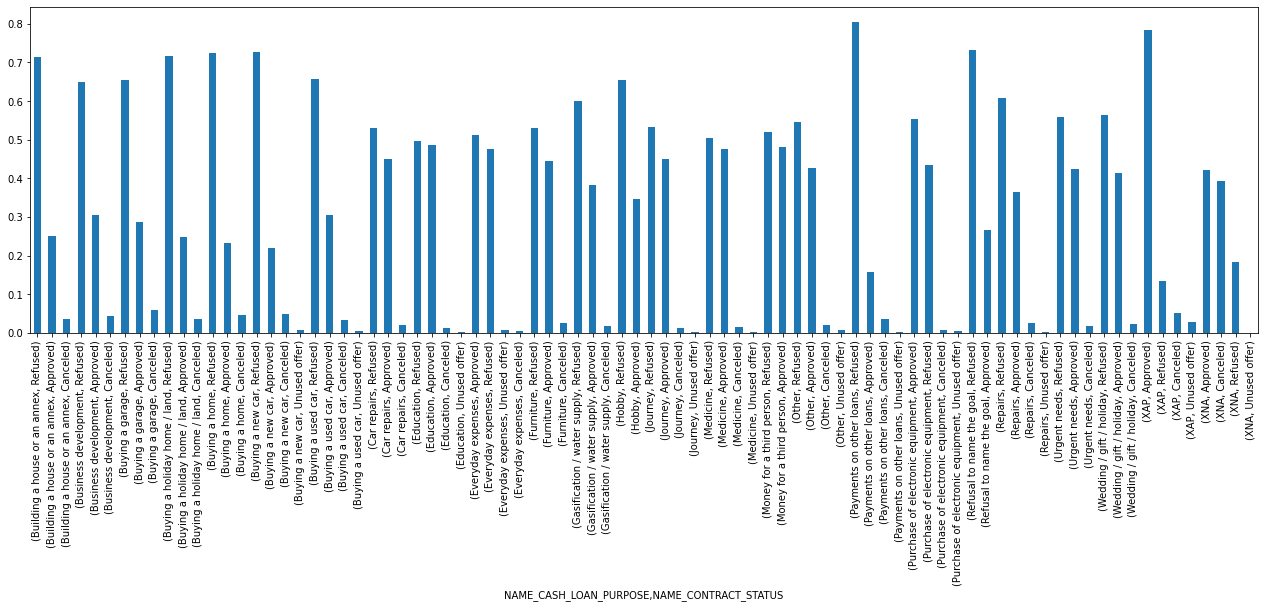

In [83]:
plt.figure(figsize=(22,6))
df_previous_application.groupby('NAME_CASH_LOAN_PURPOSE')['NAME_CONTRACT_STATUS'].value_counts(normalize=True).plot(kind='bar')
plt.show()